### Pre-requesties

In [10]:
import os
import re
import ast
import string
import tarfile
import requests
import zipfile
import pandas as pd
import numpy as np
import collections
import logging
import warnings
import tensorflow as tf
import tensorflow_datasets as tfds
import gensim
import nltk
from tempfile import NamedTemporaryFile
from bs4 import BeautifulSoup
from keras import layers
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from gensim import corpora
from transformers import logging as transformers_logging
from transformers import TFDistilBertModel, AutoTokenizer
import spacy

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

In [12]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
# Configure warnings and logging
warnings.filterwarnings("ignore")
transformers_logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tf.get_logger().setLevel(logging.ERROR)

#### Hypotheses

#### Main Hypotheses:

- Null Hypothesis (H0): Words in tweets and profiles do not have a significant effect on predicting user gender (i.e., the predictive power is random or weak).
- Alternative Hypothesis (H1): Words in tweets and profiles have a significant effect on predicting user gender (i.e., they provide strong predictive power).

#### Additional Hypotheses:
- H0: Other factors ('retweet_count', 'fav_number', 'description', 'text', 'tweet_count') are not good predictors of gender.
- H1: Other factors ('retweet_count', 'fav_number', 'description', 'text', 'tweet_count') can strongly predict gender.

### Data Preperation, Visulization

In [14]:
class Setup:
    """Class to Setup"""
    def __init__(self):
        self.setup_nltk()
        self.setup_gpu()

    @staticmethod
    def setup_nltk():
        """Download necessary NLTK datasets"""
        nltk.download('averaged_perceptron_tagger')
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download('brown')

    @staticmethod
    def setup_gpu():
        """Set up GPU configuration."""
        pass

    @staticmethod
    def section(text,n=20):
        """section text"""
        print()
        print("-"*n)
        print(text)
        print("-"*n)
        print()


In [15]:
class TextProcessor:
    """Class to process text"""
    def __init__(self):
        self.remove_words = set([
            "im", "tweet", "like", "follow", "rt", "dm", "pm",
            "#", "@", "followfriday", "ff", "l4l", "boost", "promo", "deal", "win",
            "now", "today", "tomorrow", "free", "best"
        ])
        self.stopwords_set = set(stopwords.words('english')).union(self.remove_words)
        self.lemmatizer = WordNetLemmatizer()
        self.nlp = spacy.load("en_core_web_sm")
        self.vectorizer = CountVectorizer()

    def word_cloud(self, texts):
      """Plot word cloud for text"""
      text = ' '.join(texts)
      wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
      plt.figure(figsize=(8, 8), facecolor=None)
      plt.imshow(wordcloud)
      plt.axis("off")
      plt.tight_layout(pad=0)
      plt.show()

    def denoise_text(self, text):
        """Remove unwanted characters and format text."""
        text = self.remove_whitespace(text)
        text = self.remove_html(text)
        text = self.remove_between_square_brackets(text)
        text = self.remove_url(text)
        text = self.remove_special_characters(text)
        text = self.remove_punctuation(text)
        text = self.remove_hashtags(text)
        return text

    def standardize_text(self, text):
        """Convert text to lowercase."""
        return text.lower()

    def denoise_and_standardize_and_lemmatize_text(self, text):
        """Apply denoise and standardize functions"""
        return self.lemmatize(self.standardize_text(self.denoise_text(text)))

    def lemmatize(self, text):
        """Lemmatize text, excluding all stopwords."""
        tokens = word_tokenize(text)
        return ' '.join([self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stopwords_set])


    # Bag of Words Models
    def vectorize(self, texts):
        """Vectorize text"""
        X = self.vectorizer.fit_transform(texts)
        feature_names = self.vectorizer.get_feature_names_out()
        dense_array = X.toarray()
        return dense_array, feature_names

    # Word2Vec
    def embeddings(self, texts):
        """Embeddings"""
        sentences = [text.split() for text in texts]
        model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
        return model

    def get_average_embedding(self, sentence, model):
        """Get average embedding"""
        embeddings = [model.wv[word] for word in sentence.split()]
        if len(embeddings) == 0:
            return np.zeros(model.vector_size)
        return np.mean(embeddings, axis=0)

    @staticmethod
    def remove_whitespace(text):
        """Remove Whitespace"""
        return re.sub(r'\s+', ' ', text).strip()

    @staticmethod
    def remove_html(text):
        """Remove HTML"""
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    @staticmethod
    def remove_between_square_brackets(text):
        """Remove Brackets"""
        return re.sub('\[[^]]*\]', '', text)

    @staticmethod
    def remove_url(text):
        """Remove Url"""
        return re.sub(r"(?:\@|https?\://)\S+", '', text)

    @staticmethod
    def remove_special_characters(text):
        """Remove Special Characters"""
        pattern = r'[^a-zA-Z0-9\s]'
        return re.sub(pattern, '', text)

    @staticmethod
    def remove_punctuation(text):
        """Remove Punctuation"""
        translator = str.maketrans('', '', string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§')
        return text.translate(translator)

    @staticmethod
    def remove_hashtags(text):
        """Remove Hashtags"""
        text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
        text = " ".join(word.strip() for word in re.split('#|_', text))
        return text

In [16]:
class Task1:
    def __init__(self, base_path, file):
        self.base_path = base_path
        self.file = file
        self.df = None
        self.scaler = StandardScaler()
        self.le_gender = LabelEncoder()

    def load_data(self):
      """load data"""
      self.df = pd.read_csv(os.path.join(self.base_path, self.file), encoding='latin1')

    def encode_labels(self, df):
        """Encode labels"""
        print("Encoding Gender and Brand")
        df['gender'] = df['gender'].replace({'male': 'human', 'female': 'human'})
        df['gender'] = df['gender'].replace({'brand': 'non-human'})
        df['gender'] = self.le_gender.fit_transform(df['gender'])
        return df

    def scale_features(self, df):
        """Scale numeric features using StandardScaler"""
        print("Applying Standard Scaler")
        columns_to_scale = ['fav_number','retweet_count','tweet_count']
        numerical = df[columns_to_scale]
        scaled_features = self.scaler.fit_transform(numerical)
        scaled_features_df = pd.DataFrame(
            scaled_features, columns=columns_to_scale, index=df.index)
        df[columns_to_scale] = scaled_features_df

        return df

    def preprocess_data_frame(self):
        """Select features, fill missing values, scale features, encode labels"""
        print("Selecting rows with high gender confidence")
        df = self.df.copy()
        df = df[df['gender'].isin(['female','male','brand'])]
        df = df[df['gender:confidence'] > 0.9]

        chosen_columns = {
            'gender', 'fav_number', 'retweet_count','text','tweet_count'
        }

        print(f"Selecting features: {chosen_columns}")
        df = df.loc[:, self.df.columns.intersection(chosen_columns)]

        print("Filling missing values")
        df.fillna('', inplace=True)


        print("Scaling features")
        df = self.scale_features(df)

        print("Encoding Labels")
        df = self.encode_labels(df)

        return df

    def plot_correlation_matrix(self, df, alpha=0.05):
        """Plot the correlation matrix"""

        df = df.select_dtypes(include=['int64', 'float64'])
        correlation_matrix = df.corr()

        # Initialize a DataFrame to store p-values
        p_values = pd.DataFrame(np.zeros_like(
            correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)

        # Calculate p-values
        for row in correlation_matrix.index:
            for col in correlation_matrix.index:
                if row == col:
                    # p-value is 0 for diagonal elements
                    p_values.loc[row, col] = 0.0
                else:
                    _, p_val = stats.pearsonr(df[row], df[col])

                    p_values.loc[row, col] = p_val

        # Create a mask for significant correlations
        significant_mask = p_values < alpha

        # Plot the correlation matrix with a mask
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=~significant_mask,
                    cbar_kws={"label": "Correlation Coefficient"}, annot_kws={"size": 10})

        plt.title('Significant Correlations')
        plt.show()

        return correlation_matrix, p_values

    def plot_pairplot(self, df):
        """Plot the scatterplot matrix"""
        df = df.select_dtypes(include=['int64', 'float64'])
        sns.pairplot(df)
        plt.suptitle('Scatterplot Matrix', y=1.02)  # Add a title
        plt.show()

In [17]:
"""main function"""
Setup.section("Assignment 2 - Group 17")

Setup.setup_nltk()


--------------------
Assignment 2 - Group 17
--------------------



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [18]:
Setup.section("Task 1 - Data Preparation")

base_path = r'.'
file = "twitter_user_data.csv"
task1 = Task1(base_path, file)
task1.load_data()
df_preprocessed = task1.preprocess_data_frame()


--------------------
Task 1 - Data Preparation
--------------------

Selecting rows with high gender confidence
Selecting features: {'gender', 'text', 'tweet_count', 'fav_number', 'retweet_count'}
Filling missing values
Scaling features
Applying Standard Scaler
Encoding Labels
Encoding Gender and Brand


In [19]:
df_preprocessed['gender'].value_counts()

,count
gender,
0,10023
1,3787


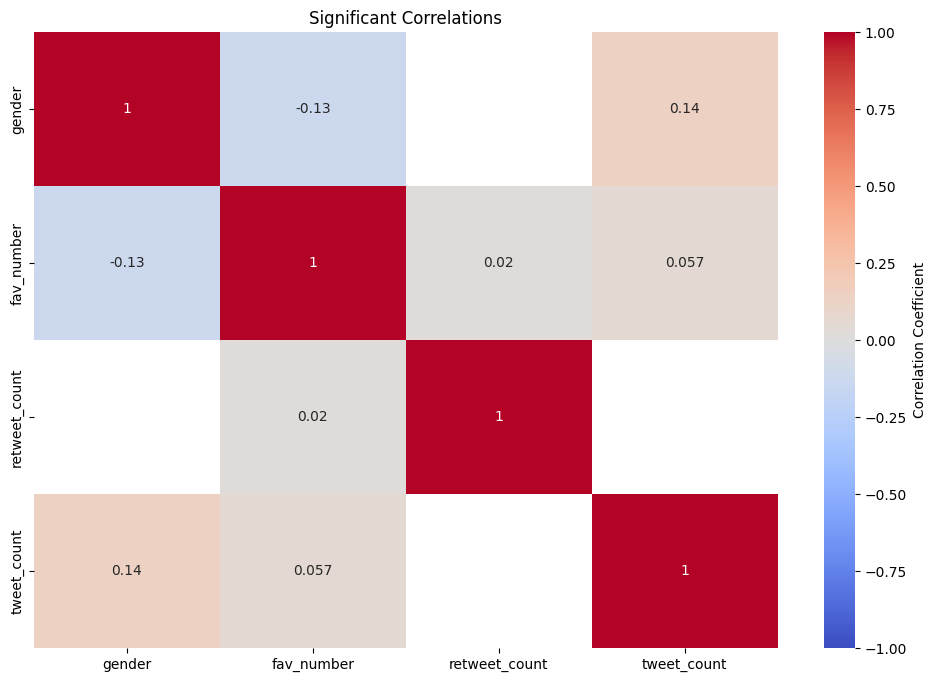

In [20]:
_, p_values = task1.plot_correlation_matrix(df_preprocessed)

In [21]:
print("P values for twitter data")
p_values

P values for twitter data


,gender,fav_number,retweet_count,tweet_count
gender,0.000000e+00,8.695484e-55,0.861881,1.074486e-60
fav_number,8.695484e-55,0.000000e+00,0.017874,2.134321e-11
retweet_count,8.618808e-01,1.787372e-02,0.000000,9.691600e-01
tweet_count,1.074486e-60,2.134321e-11,0.969160,0.000000e+00


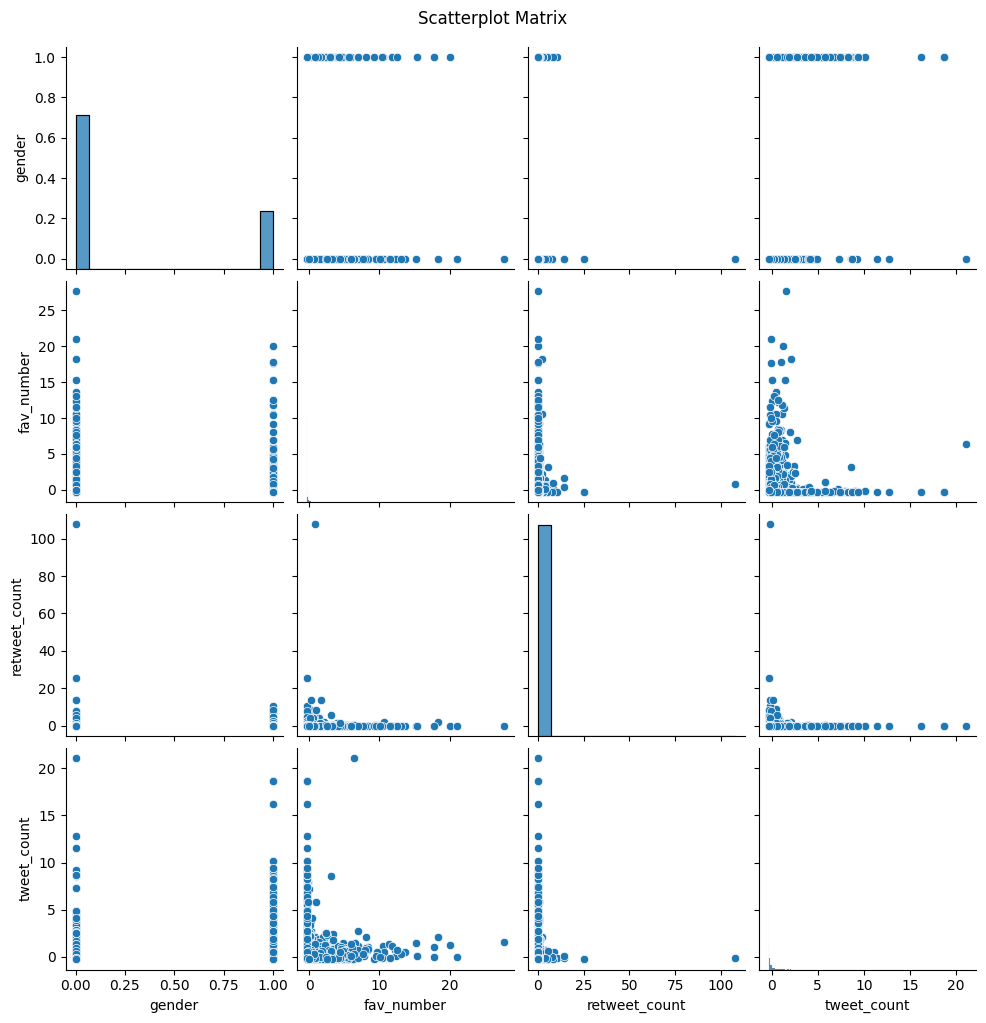

In [22]:
task1.plot_pairplot(df_preprocessed)

In [23]:
text_processor = TextProcessor()
df_preprocessed['text'] = df_preprocessed['text'].apply(text_processor.denoise_and_standardize_and_lemmatize_text)

Word cloud for tweet


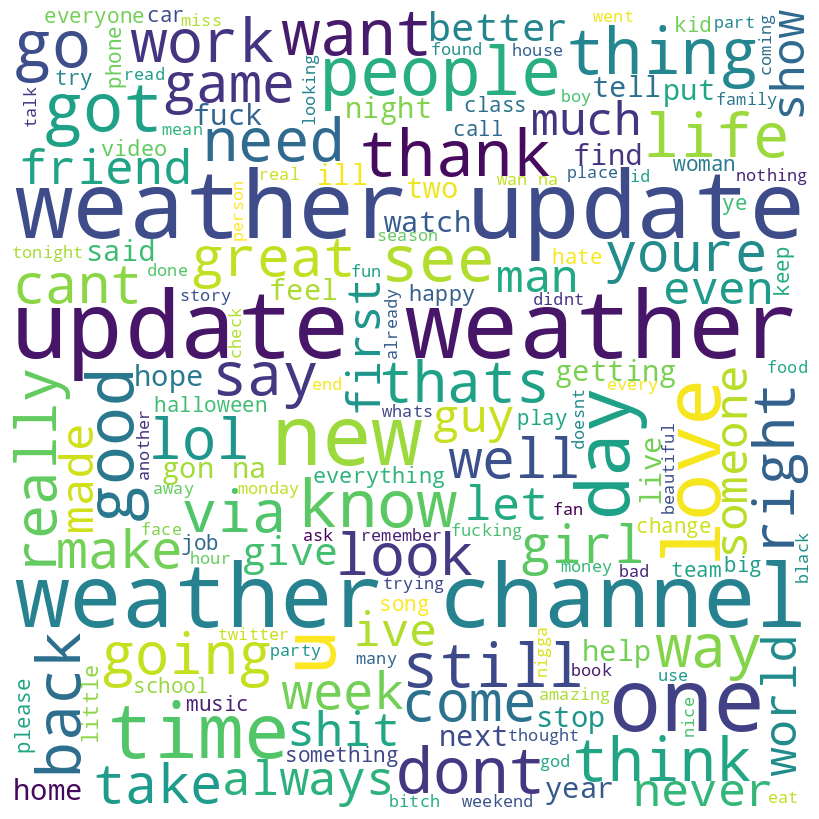

In [24]:
print("Word cloud for tweet")
text_processor.word_cloud(df_preprocessed['text'].ravel())

In [25]:
## BAG OF WORDS MODLE
bow_dense_array, bow_feature_names = text_processor.vectorize(df_preprocessed['text'])
df_preprocessed['bow_feature'] = bow_dense_array.tolist()

In [26]:
### Word2Vec
model = text_processor.embeddings(df_preprocessed['text'])
word2vec_embeddings = [text_processor.get_average_embedding(text, model) for text in df_preprocessed['text']]

In [27]:
df_preprocessed['word2vec_embeddings'] = word2vec_embeddings

### Clustering

In [28]:
#### Use the df_preprocessed to perform clustering, I have applied the bag of words and word2vec model on user tweet
df_preprocessed.head()

,gender,fav_number,retweet_count,text,tweet_count,bow_feature,word2vec_embeddings
0,0,-0.348345,-0.047969,robbie e responds critic eddie edward worldtit...,0.582729,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.027771177, -0.011534505, 0.011301337, -0.01..."
1,0,-0.342754,-0.047969,felt friend living story retired ian1,-0.244501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.15577702, -0.06384336, 0.04264154, -0.06985..."
3,0,-0.331736,-0.047969,hi looking url use dont typically see advanced...,-0.290685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.27020037, -0.13483101, 0.06586221, -0.11416..."
4,0,2.719920,-0.047969,watching neighbour sky catching neighbs xxx xxx,-0.052738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04499659, -0.022171868, 0.017824737, -0.026..."
5,0,-0.027607,-0.047969,ive seen people train lamp chair tv etc,-0.144067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.22067426, -0.10848004, 0.05747426, -0.09701..."


In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class KMeansModel:
    def __init__(self, n_clusters=5, random_state=42):
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=self.n_clusters, random_state=random_state)

    def train(self, X):
        self.labels = self.model.fit_predict(X)

    def evaluate(self, X):
        self.silhouette_score = silhouette_score(X, self.labels)
        print("K-Means Silhouette Score:", self.silhouette_score)

    def visualize(self, X):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.labels, cmap='viridis')
        plt.title(f'K-Means Clustering (Silhouette: {self.silhouette_score:.2f})')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.show()


In [30]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class DBSCANModel:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.model = DBSCAN(eps=self.eps, min_samples=self.min_samples)

    def train(self, X):
        self.labels = self.model.fit_predict(X)

    def evaluate(self, X):
        # Exclude noise points (-1) for Silhouette Score calculation
        if len(set(self.labels)) > 1 and len(self.labels[self.labels != -1]) > 0:
            self.silhouette_score = silhouette_score(X[self.labels != -1], self.labels[self.labels != -1])
            print(f"DBSCAN Silhouette Score: {self.silhouette_score}")
        else:
            print("Silhouette score cannot be computed with only one cluster or all points labeled as noise.")

    def visualize(self, X):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.labels, cmap='viridis')
        plt.title('DBSCAN Clustering')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.show()


In [31]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=d43e2e1efe615400aef942db54aea727cc88764ac283f23f0d4034d9a3ecc20f
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom

class SOMModel:
    def __init__(self, x=10, y=10, input_len=10, sigma=1.0, learning_rate=0.5):
        self.som = MiniSom(x=x, y=y, input_len=input_len, sigma=sigma, learning_rate=learning_rate)
        self.x = x
        self.y = y

    def train(self, X, num_iterations=100):
        self.som.random_weights_init(X)
        self.som.train_random(X, num_iterations)
        self.labels = np.array([self.som.winner(x) for x in X])
        print(f"SOM trained with {num_iterations} iterations")

    def evaluate(self, X):
        quantization_error = np.mean([np.linalg.norm(x - self.som.get_weights()[self.som.winner(x)]) for x in X])
        print(f"Quantization Error: {quantization_error}")

        # Number of unique nodes (clusters)
        unique_nodes = len(set(map(tuple, self.labels)))
        print(f"SOM Number of unique nodes (clusters): {unique_nodes}")


    def visualize(self, X, data_labels=None):
        plt.figure(figsize=(10, 10))
        # Get the SOM grid
        distance_map = self.som.distance_map().T

        # Heatmap creation
        plt.imshow(distance_map, cmap='bone_r', interpolation='nearest')
        plt.colorbar(label='Distance from Neurons')

        # Plot points on the heatmap, using colors based on labels or assigning random colors if no labels are available
        for i, (x, label) in enumerate(zip(X, data_labels if data_labels is not None else [str(i) for i in range(len(X))])):
            w = self.som.winner(x)  # Get the winning node
            plt.text(w[0], w[1], str(label), color='red', ha='center', va='center', fontsize=12,
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.2'))

        plt.title('Self-Organizing Map (SOM) Visualization')
        plt.show()


K-Means Silhouette Score: 0.3660791211082592


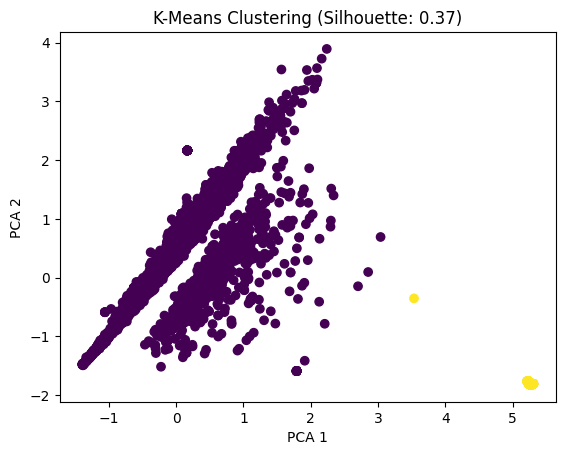

DBSCAN Silhouette Score: 0.9949177380625823


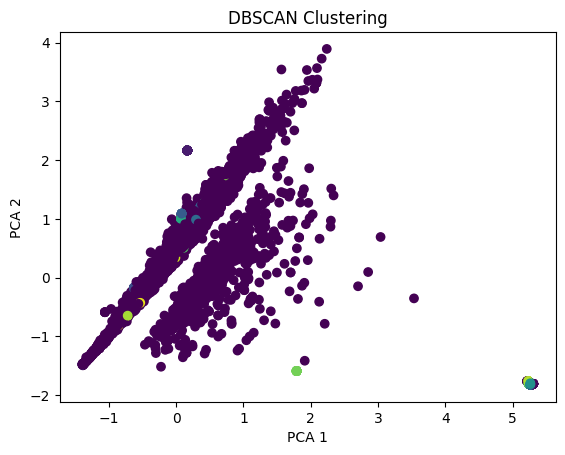

SOM trained with 200 iterations
Quantization Error: 2.970471037865616
SOM Number of unique nodes (clusters): 25


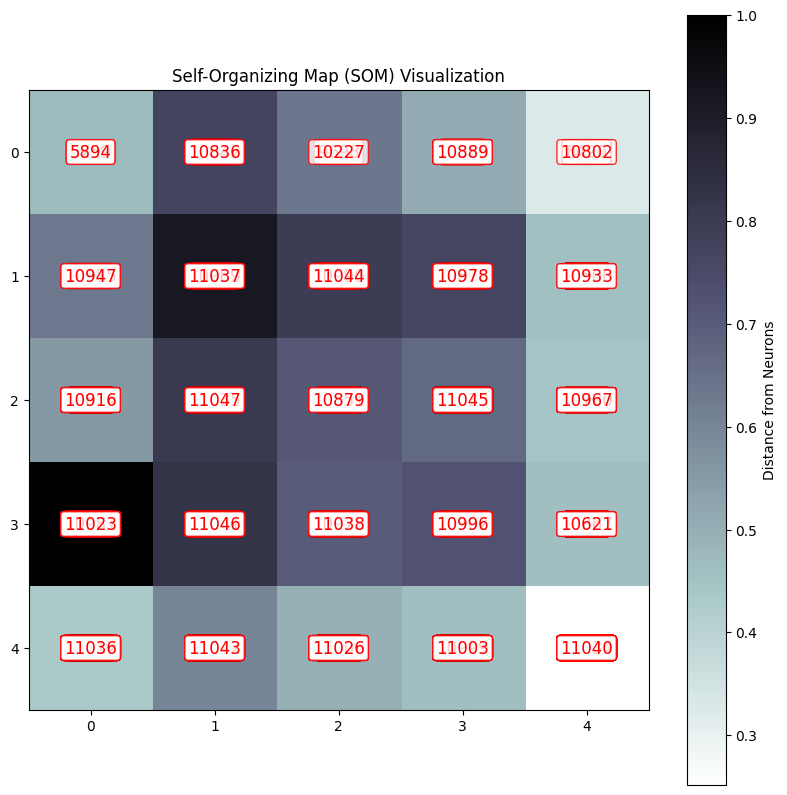

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split



# Features there would be no targets since it's unsupervised learning
X = np.hstack([np.array(df_preprocessed['bow_feature'].tolist()),
               np.array(df_preprocessed['word2vec_embeddings'].tolist())])

# Split the data into training and testing sets for visualization purposes
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Initialize and evaluate clustering models

# K-Means Model

kmeans_model = KMeansModel(n_clusters=2)  # k=2 clusters
kmeans_model.train(X_train)
kmeans_model.evaluate(X_train)  # K-Means does not use a test set, but evaluation happens on the training data
kmeans_model.visualize(X_train)

# DBSCAN Model
dbscan_model = DBSCANModel(eps=0.5, min_samples=5)
dbscan_model.train(X_train)
dbscan_model.evaluate(X_train)  # DBSCAN does not use a test set, but evaluation happens on the training data
dbscan_model.visualize(X_train)

# SOM Model
som_model = SOMModel(x=5, y=5, input_len=X_train.shape[1])
som_model.train(X_train, num_iterations=200)
som_model.evaluate(X_train) #SOM does not use a test set, but evaluation happens on the training data
som_model.visualize(X_train)
